# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Данные для этой задачи взяты из исследования, проведённого в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

In [1]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
gen = pd.read_csv('gene_high_throughput_sequencing.csv')
gen.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


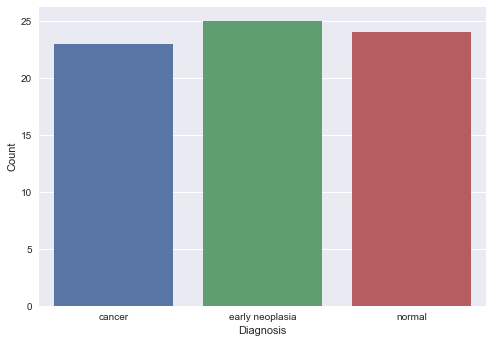

In [22]:
types, cnts = np.unique(gen.Diagnosis.values, return_counts=True)
_ = sns.barplot(types, cnts)
_ = plt.xlabel('Diagnosis')
_ = plt.ylabel('Count')

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания представлена именно эта количественная мера активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

#### Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

Fc(C,T)=T/C при T>C и -T/C при T<C,

где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

#### Часть 1: применение t-критерия Стьюдента

В первой части нужно применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

* для групп normal (control) и early neoplasia (treatment)
* для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые мы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [25]:
#Diagnosis types
types

array(['cancer', 'early neoplasia', 'normal'], dtype=object)

In [24]:
#Split data by groups
gen_normal = gen.loc[gen.Diagnosis == 'normal']
gen_neoplasia = gen.loc[gen.Diagnosis == 'early neoplasia']
gen_cancer = gen.loc[gen.Diagnosis == 'cancer']

Для того, чтобы использовать двухвыборочный критерий Стьюдента, убедимся, что распределения в выборках существенно не отличаются от нормальных, применив критерий Шапиро-Уилка.

In [62]:
#Shapiro-Wilk test for samples
print('Shapiro-Wilk test for samples')

sw_normal = gen_normal.iloc[:,2:].apply(stats.shapiro, axis=0)
sw_normal_p = [p for _, p in sw_normal]
_, sw_normal_p_corr, _, _ = multipletests(sw_normal_p, method='fdr_bh')

sw_neoplasia = gen_neoplasia.iloc[:,2:].apply(stats.shapiro, axis=0)
sw_neoplasia_p = [p for _, p in sw_neoplasia]
_, sw_neoplasia_p_corr, _, _ = multipletests(sw_neoplasia_p, method='fdr_bh')

sw_cancer = gen_cancer.iloc[:,2:].apply(stats.shapiro, axis=0)
sw_cancer_p = [p for _, p in sw_cancer]
_, sw_cancer_p_corr, _, _ = multipletests(sw_cancer_p, method='fdr_bh')

print('Mean corrected p-value for "normal": %.4f' % sw_normal_p_corr.mean())
print('Mean corrected p-value for "early neoplasia": %.4f' % sw_neoplasia_p_corr.mean())
print('Mean corrected p-value for "cancer": %.4f' % sw_cancer_p_corr.mean())

Shapiro-Wilk test for samples
Mean corrected p-value for "normal": 0.4892
Mean corrected p-value for "early neoplasia": 0.5025
Mean corrected p-value for "cancer": 0.4594


Так как среднее значение p-value >> 0.05, то будем применять критерий Стьюдента.

In [139]:
tt_ind_normal_neoplasia = stats.ttest_ind(gen_normal.iloc[:,2:], gen_neoplasia.iloc[:,2:], equal_var = False)
tt_ind_normal_neoplasia_p = tt_ind_normal_neoplasia[1]

tt_ind_neoplasia_cancer = stats.ttest_ind(gen_neoplasia.iloc[:,2:], gen_cancer.iloc[:,2:], equal_var = False)
tt_ind_neoplasia_cancer_p = tt_ind_neoplasia_cancer[1]

tt_ind_normal_neoplasia_p_5 = tt_ind_normal_neoplasia_p[np.where(tt_ind_normal_neoplasia_p < 0.05)].shape[0]
tt_ind_neoplasia_cancer_p_5 = tt_ind_neoplasia_cancer_p[np.where(tt_ind_neoplasia_cancer_p < 0.05)].shape[0]

print('Normal vs neoplasia samples p-values number below 0.05: %d' % tt_ind_normal_neoplasia_p_5)
print('Neoplasia vs cancer samples p-values number below 0.05: %d' % tt_ind_neoplasia_cancer_p_5)

Normal vs neoplasia samples p-values number below 0.05: 1575
Neoplasia vs cancer samples p-values number below 0.05: 3490


In [86]:
with open('answer1.txt', 'w') as fout:
    fout.write(str(tt_ind_normal_neoplasia_p_5))
    
with open('answer2.txt', 'w') as fout:
    fout.write(str(tt_ind_neoplasia_cancer_p_5))

#### Часть 2: поправка методом Холма

Для этой части задания нам понадобится модуль multitest из statsmodels.

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратим внимание, что поскольку мы будем делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитать для каждого значимого изменения fold change и выписать в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

Обратим внимание, что

* применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия;
* при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [138]:
#Holm correction
_, tt_ind_normal_neoplasia_p_corr, _, _ = multipletests(tt_ind_normal_neoplasia_p, method='holm')
_, tt_ind_neoplasia_cancer_p_corr, _, _ = multipletests(tt_ind_neoplasia_cancer_p, method='holm')

#Bonferroni correction
p_corr = np.array([tt_ind_normal_neoplasia_p_corr, tt_ind_neoplasia_cancer_p_corr])
_, p_corr_bonf, _, _ = multipletests(p_corr, is_sorted=True, method='bonferroni')

p_corr_bonf_normal_neoplasia_p_5 = p_corr_bonf[0][np.where(p_corr_bonf[0] < 0.05)].shape[0]
p_corr_bonf_neoplasia_cancer_p_5 = p_corr_bonf[1][np.where(p_corr_bonf[1] < 0.05)].shape[0]

print('Normal vs neoplasia samples p-values number below 0.05: %d' % p_corr_bonf_normal_neoplasia_p_5)
print('Neoplasia vs cancer samples p-values number below 0.05: %d' % p_corr_bonf_neoplasia_cancer_p_5)

Normal vs neoplasia samples p-values number below 0.05: 2
Neoplasia vs cancer samples p-values number below 0.05: 79


In [162]:
def fold_change(C, T, limit=1.5):
    '''
    C - control sample
    T - treatment sample
    '''
    if T >= C:
        fc_stat = T / C
    else:
        fc_stat = -C / T
    
    return (np.abs(fc_stat) > limit), fc_stat

In [165]:
#Normal vs neoplasia samples
gen_p_corr_bonf_normal_p_5 = gen_normal.iloc[:,2:].iloc[:, np.where(p_corr_bonf[0] < 0.05)[0]]
gen_p_corr_bonf_neoplasia0_p_5 = gen_neoplasia.iloc[:,2:].iloc[:, np.where(p_corr_bonf[0] < 0.05)[0]]

fc_corr_bonf_normal_neoplasia_p_5 = 0
for norm, neopl in zip(gen_p_corr_bonf_normal_p_5.mean(), gen_p_corr_bonf_neoplasia0_p_5.mean()):
    accept, _ = fold_change(norm, neopl)
    if accept: fc_corr_bonf_normal_neoplasia_p_5 += 1

#Neoplasia vs cancer samples
gen_p_corr_bonf_neoplasia1_p_5 = gen_neoplasia.iloc[:,2:].iloc[:, np.where(p_corr_bonf[1] < 0.05)[0]]
gen_p_corr_bonf_cancer_p_5 = gen_cancer.iloc[:,2:].iloc[:, np.where(p_corr_bonf[1] < 0.05)[0]]

fc_corr_bonf_neoplasia_cancer_p_5 = 0
for neopl, canc in zip(gen_p_corr_bonf_neoplasia1_p_5.mean(), gen_p_corr_bonf_cancer_p_5.mean()):
    accept, _ = fold_change(neopl, canc)
    if accept: fc_corr_bonf_neoplasia_cancer_p_5 += 1

print('Normal vs neoplasia samples fold change above 1.5: %d' % fc_corr_bonf_normal_neoplasia_p_5)
print('Neoplasia vs cancer samples fold change above 1.5: %d' % fc_corr_bonf_neoplasia_cancer_p_5)

Normal vs neoplasia samples fold change above 1.5: 2
Neoplasia vs cancer samples fold change above 1.5: 77


In [166]:
with open('answer3.txt', 'w') as fout:
    fout.write(str(fc_corr_bonf_normal_neoplasia_p_5))
    
with open('answer4.txt', 'w') as fout:
    fout.write(str(fc_corr_bonf_neoplasia_cancer_p_5))

#### Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратим внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от H0, когда они есть, и будут чаще отклонять H0, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [167]:
#Benjamini-Hochberg correction
_, tt_ind_normal_neoplasia_p_corr, _, _ = multipletests(tt_ind_normal_neoplasia_p, method='fdr_bh')
_, tt_ind_neoplasia_cancer_p_corr, _, _ = multipletests(tt_ind_neoplasia_cancer_p, method='fdr_bh')

#Bonferroni correction
p_corr = np.array([tt_ind_normal_neoplasia_p_corr, tt_ind_neoplasia_cancer_p_corr])
_, p_corr_bonf, _, _ = multipletests(p_corr, is_sorted=True, method='bonferroni')

p_corr_bonf_normal_neoplasia_p_5 = p_corr_bonf[0][np.where(p_corr_bonf[0] < 0.05)].shape[0]
p_corr_bonf_neoplasia_cancer_p_5 = p_corr_bonf[1][np.where(p_corr_bonf[1] < 0.05)].shape[0]

print('Normal vs neoplasia samples p-values number below 0.05: %d' % p_corr_bonf_normal_neoplasia_p_5)
print('Neoplasia vs cancer samples p-values number below 0.05: %d' % p_corr_bonf_neoplasia_cancer_p_5)

Normal vs neoplasia samples p-values number below 0.05: 4
Neoplasia vs cancer samples p-values number below 0.05: 832


In [168]:
#Normal vs neoplasia samples
gen_p_corr_bonf_normal_p_5 = gen_normal.iloc[:,2:].iloc[:, np.where(p_corr_bonf[0] < 0.05)[0]]
gen_p_corr_bonf_neoplasia0_p_5 = gen_neoplasia.iloc[:,2:].iloc[:, np.where(p_corr_bonf[0] < 0.05)[0]]

fc_corr_bonf_normal_neoplasia_p_5 = 0
for norm, neopl in zip(gen_p_corr_bonf_normal_p_5.mean(), gen_p_corr_bonf_neoplasia0_p_5.mean()):
    accept, _ = fold_change(norm, neopl)
    if accept: fc_corr_bonf_normal_neoplasia_p_5 += 1

#Neoplasia vs cancer samples
gen_p_corr_bonf_neoplasia1_p_5 = gen_neoplasia.iloc[:,2:].iloc[:, np.where(p_corr_bonf[1] < 0.05)[0]]
gen_p_corr_bonf_cancer_p_5 = gen_cancer.iloc[:,2:].iloc[:, np.where(p_corr_bonf[1] < 0.05)[0]]

fc_corr_bonf_neoplasia_cancer_p_5 = 0
for neopl, canc in zip(gen_p_corr_bonf_neoplasia1_p_5.mean(), gen_p_corr_bonf_cancer_p_5.mean()):
    accept, _ = fold_change(neopl, canc)
    if accept: fc_corr_bonf_neoplasia_cancer_p_5 += 1

print('Normal vs neoplasia samples fold change above 1.5: %d' % fc_corr_bonf_normal_neoplasia_p_5)
print('Neoplasia vs cancer samples fold change above 1.5: %d' % fc_corr_bonf_neoplasia_cancer_p_5)

Normal vs neoplasia samples fold change above 1.5: 4
Neoplasia vs cancer samples fold change above 1.5: 524


In [169]:
with open('answer5.txt', 'w') as fout:
    fout.write(str(fc_corr_bonf_normal_neoplasia_p_5))
    
with open('answer6.txt', 'w') as fout:
    fout.write(str(fc_corr_bonf_neoplasia_cancer_p_5))